# Анализ бизнес показателей

### Цель проекта:

Я - маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несколько прошлых месяцев бизнес постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Нужно разобраться в причинах этой ситуации.

У нас в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Вам предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отрицательно влияют на привлечение пользователей.


#### Описание данных
Таблица visits (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

# Шаг 1. Загрузка данных и подготовка их к анализу

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from IPython.display import HTML, display
from scipy import stats as st
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
visits, orders, ad_costs = (
    pd.read_csv('C:\\Users\\SpectNSK\\Desktop\\projects\\data set\\bp\\visits_info_short.csv'),  # журнал сессий
    pd.read_csv('C:\\Users\\SpectNSK\\Desktop\\projects\\data set\\bp\\orders_info_short.csv'),  # покупки
   pd.read_csv('C:\\Users\\SpectNSK\\Desktop\\projects\\data set\\bp\\costs_info_short.csv'),  # траты на рекламу
)
events = None

In [3]:
visits.columns = [x.lower().replace(' ', '_') for x in visits.columns.values]
orders.columns = [x.lower().replace(' ', '_') for x in orders.columns.values]
ad_costs.columns = [x.lower().replace(' ', '_') for x in ad_costs.columns.values]


In [4]:
display(orders)

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99
...,...,...,...
40207,651604369137,2019-10-31 16:19:07,4.99
40208,275341387049,2019-10-31 01:17:17,4.99
40209,374656616484,2019-10-31 06:17:29,4.99
40210,168548862926,2019-10-31 22:46:19,4.99


In [5]:
visits['session_start'] = pd.to_datetime(visits['session_start'], format = '%Y-%m-%d %H:%M:%S')
visits['session_end'] = pd.to_datetime(visits['session_end'], format = '%Y-%m-%d %H:%M:%S')
orders['event_dt'] = pd.to_datetime(orders['event_dt'], format = '%Y-%m-%d %H:%M:%S')
ad_costs['dt'] = pd.to_datetime(ad_costs['dt']).dt.date

In [6]:
visits.info()
visits.duplicated().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


0

In [7]:
orders.info()
orders.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


0

In [8]:
ad_costs.info()
ad_costs.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


0

Вывод:
Дубликатов нет. Типы данных соотвествуют значениям.

# Шаг 2. Исследовательский анализ данных

Построим профили пользователей

Узнаем:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

In [9]:
def get_profiles(visits, orders, events, ad_costs, event_names=[]):

    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    
    # проверьте, есть ли ID пользователей из profiles в orders
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

# строим профили по двум наборам данных
profiles = get_profiles(visits, orders, events, ad_costs)

print(
    profiles.groupby('region').agg({'payer': 'mean', 'user_id': 'nunique'}).sort_values(by='payer',ascending = False)
    )

                  payer  user_id
region                          
United States  0.069019   100002
Germany        0.041119    14981
UK             0.039829    17575
France         0.037994    17450


In [10]:
display(profiles.head(5))
print(profiles['first_ts'].min())
print(profiles['first_ts'].max())

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


2019-05-01 00:00:41
2019-10-27 23:59:04


Вывод:
В наше приложениях в основном приходят жители США, а так же Германии, Великобритании и Франции. Доля платящих максимальна в США

In [11]:
print(
    profiles.groupby('device').agg({'payer': 'mean', 'user_id': 'nunique'}).sort_values(by = 'payer', ascending = False))

            payer  user_id
device                    
Mac      0.063644    30042
iPhone   0.062079    54479
Android  0.058518    35032
PC       0.050468    30455


Вывод:
В приложение заходят с 4 платформ: Mac, Iphone, Android и PC. Наибольший процент платящих у Мака и Айфона

In [12]:
profiles.groupby('channel').agg({'payer': 'mean', 'user_id': 'nunique'}).sort_values(by = 'payer', ascending = False)

,payer,user_id
channel,,
FaceBoom,0.122049,29144
AdNonSense,0.113402,3880
lambdaMediaAds,0.104700,2149
TipTop,0.096007,19561
RocketSuperAds,0.079137,4448
WahooNetBanner,0.052964,8553
YRabbit,0.038265,4312
MediaTornado,0.035747,4364
LeapBob,0.030633,8553


Вывод: 
У нас много каналов привлечения. Лучший канал привлечения FaceBoom

# Шаг 3. Отчёты и метрики
Продукт:

-    Сколько людей пользуются в день, неделю, месяц?
-    Сколько сессий в день?
-    Сколько длится одна сессия?

Продажи:

- Когда люди начинают покупать?
- Сколько покупок делает в среднем платящий пользователь за месяц, неделю, день?
- Какой средний чек за месяц, неделю, день?

Маркетинг:

- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

### Продукт:
-    Сколько людей пользуются в день, неделю, месяц?

In [13]:
visits['session_year'] = visits['session_start'].dt.year
visits['session_month'] = visits['session_start'].dt.month
visits['session_week'] = visits['session_start'].dt.week
visits['session_date'] = visits['session_start'].dt.date

1684
8353
28989


Text(0, 0.5, 'user_id')

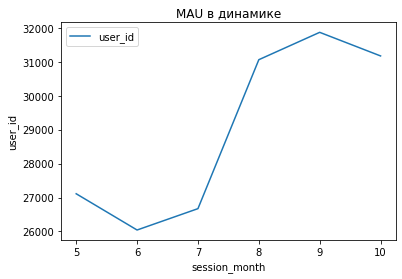

In [14]:
dau_total = (visits.groupby('session_date')
    .agg({'user_id': 'nunique'})
    .mean())

wau_total = (visits.groupby(['session_year', 'session_week'])
    .agg({'user_id': 'nunique'})
    .mean()) 

mau_total = (visits.groupby(['session_year', 'session_month'])
    .agg({'user_id': 'nunique'})
    .mean())

print(int(dau_total))
print(int(wau_total)) 
print(int(mau_total))
(visits.groupby(['session_month'])
    .agg({'user_id': 'nunique'})).plot()
plt.title('MAU в динамике')
plt.ylabel('user_id')

Text(0, 0.5, 'user_id')

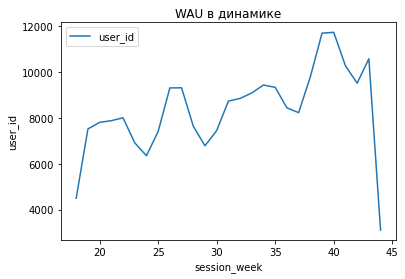

In [15]:
(visits.groupby(['session_week'])
    .agg({'user_id': 'nunique'})).plot()
plt.title('WAU в динамике')
plt.ylabel('user_id')

Text(0, 0.5, 'user_id')

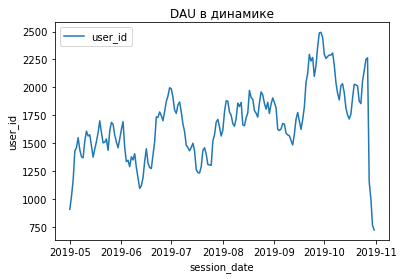

In [16]:
(visits.groupby(['session_date'])
    .agg({'user_id': 'nunique'})).plot()
plt.title('DAU в динамике')
plt.ylabel('user_id')

-    Сколько сессий в день?

user_id
session_year session_date         
2019         2019-05-01        909
             2019-05-02       1026
             2019-05-03       1170
             2019-05-04       1429
             2019-05-05       1463
...                            ...
             2019-10-27       2265
             2019-10-28       1155
             2019-10-29       1005
             2019-10-30        764
             2019-10-31        724

[184 rows x 1 columns]

array([[<AxesSubplot:title={'center':'user_id'}>]], dtype=object)

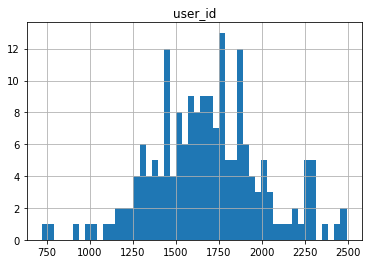

In [17]:
visits_per_user = visits.groupby(['session_year', 'session_date']).agg(
    {'user_id': 'count'})

display(visits_per_user)
visits_per_user.hist(bins=50)
#Понимаю,что график не верный,но как сделать верный я придумать не смог(

-    Сколько длится одна сессия?

1800.0908677287264


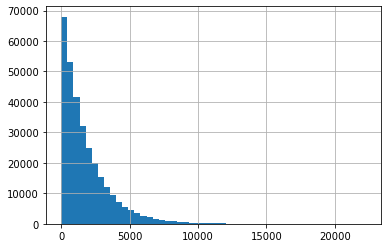

count    309901.000000
mean       1800.090868
std        1803.063525
min           0.000000
25%         517.000000
50%        1244.000000
75%        2497.000000
max       22257.000000
Name: session_duration_sec, dtype: float64

In [18]:
visits['session_duration_sec'] = (
    visits['session_end'] - visits['session_start']
).dt.seconds

print(visits['session_duration_sec'].mean()) 


visits['session_duration_sec'].hist(bins=50)
plt.show()

visits['session_duration_sec'].describe()

In [19]:
print(visits['session_duration_sec'].median()) 

1244.0


### Продажи:

- Когда люди начинают покупать?

In [20]:
orders_users = orders.groupby('user_id')['event_dt'].agg([('event_dt', 'first')])
#.agg({'event_dt' : 'first'})

In [21]:
result_raw = profiles.merge(
    orders_users, on='user_id', how='left'
)

display(result_raw)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost,event_dt
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172,2019-05-07 20:59:09
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237,NaT
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000,NaT
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235,NaT
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769,NaT
...,...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.500000,NaT
150004,999975439887,2019-10-21 00:35:17,organic,PC,UK,2019-10-21,2019-10-01,False,0.000000,NaT
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000,NaT
150006,999979924135,2019-09-28 21:28:09,MediaTornado,PC,United States,2019-09-28,2019-09-01,False,0.205714,NaT


In [22]:
profiles_payer = result_raw.query('payer == True')
profiles_payer['first_order_sec'] = (profiles_payer['event_dt'] - profiles_payer['first_ts']).dt.seconds
display(profiles_payer)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost,event_dt,first_order_sec
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172,2019-05-07 20:59:09,12
7,46006712,2019-06-30 03:46:29,AdNonSense,Android,France,2019-06-30,2019-06-01,True,1.008000,2019-06-30 03:46:52,23
61,374052872,2019-08-08 15:42:57,TipTop,Mac,United States,2019-08-08,2019-08-01,True,2.972222,2019-08-16 07:44:47,57710
71,414791703,2019-05-03 12:01:28,TipTop,iPhone,United States,2019-05-03,2019-05-01,True,1.049180,2019-05-04 18:06:41,21913
124,785077127,2019-06-27 08:31:39,TipTop,Mac,United States,2019-06-27,2019-06-01,True,2.539062,2019-06-30 18:35:15,36216
...,...,...,...,...,...,...,...,...,...,...,...
149936,999625937544,2019-10-26 06:24:00,YRabbit,Android,United States,2019-10-26,2019-10-01,True,0.270000,2019-10-26 06:24:27,27
149943,999645428220,2019-10-01 05:35:55,TipTop,Mac,United States,2019-10-01,2019-10-01,True,3.570946,2019-10-01 05:36:23,28
149946,999659859721,2019-09-04 10:33:02,organic,Mac,France,2019-09-04,2019-09-01,True,0.000000,2019-09-08 01:28:08,53706
149972,999779032958,2019-07-04 10:56:11,TipTop,iPhone,United States,2019-07-04,2019-07-01,True,2.620313,2019-07-05 23:28:13,45122


In [23]:
print(profiles_payer['first_order_sec'].mean())
print(profiles_payer['first_order_sec'].median())

15593.766580340052
33.0


<AxesSubplot:>

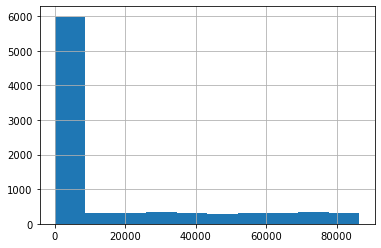

In [24]:
profiles_payer['first_order_sec'].hist()

- Сколько покупок делает в среднем платящий пользователь за месяц, неделю, день?

In [25]:
orders['event_year'] = orders['event_dt'].dt.year
orders['event_month'] = orders['event_dt'].dt.month
orders['event_week'] = orders['event_dt'].dt.week
orders['event_date'] = orders['event_dt'].dt.date
orders_user_day = orders.groupby(['user_id', 'event_date']).agg({'event_date' : 'count'}).mean()
print(orders_user_day)
orders_user_week = orders.groupby(['user_id', 'event_week']).agg({'event_week' : 'count'}).mean()
print(orders_user_week)
orders_user_month = orders.groupby(['user_id', 'event_month']).agg({'event_month' : 'count'}).mean()
print(orders_user_month)

event_date    1.00005
dtype: float64
event_week    1.306221
dtype: float64
event_month    2.182233
dtype: float64


Text(0, 0.5, 'user_id')

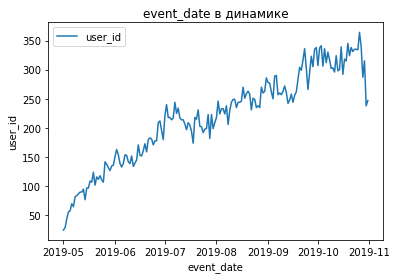

In [26]:
(orders.groupby(['event_date'])
    .agg({'user_id': 'nunique'})).plot()
plt.title('event_date в динамике')
plt.ylabel('user_id')

Text(0, 0.5, 'user_id')

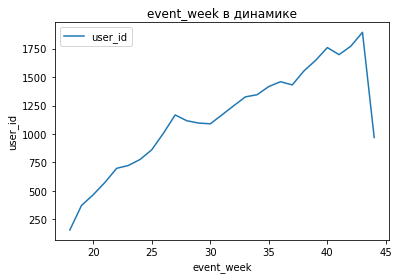

In [27]:
(orders.groupby(['event_week'])
    .agg({'user_id': 'nunique'})).plot()
plt.title('event_week в динамике')
plt.ylabel('user_id')

Text(0, 0.5, 'user_id')

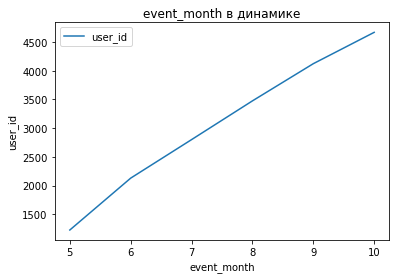

In [28]:
(orders.groupby(['event_month'])
    .agg({'user_id': 'nunique'})).plot()
plt.title('event_month в динамике')
plt.ylabel('user_id')

- Какой средний чек за месяц, неделю, день?

<AxesSubplot:xlabel='event_date'>

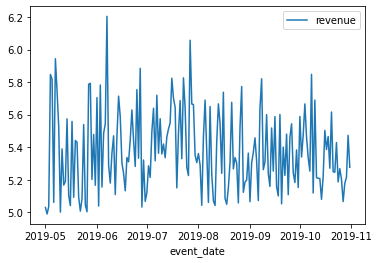

In [29]:
orders.groupby('event_date').agg({'revenue' : 'mean'}).plot()

<AxesSubplot:xlabel='event_week'>

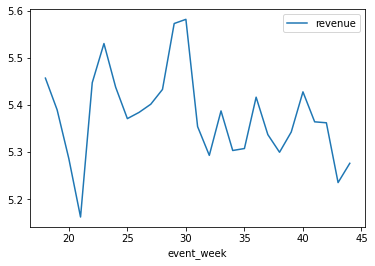

In [30]:
orders.groupby('event_week').agg({'revenue' : 'mean'}).plot()

<AxesSubplot:xlabel='event_month'>

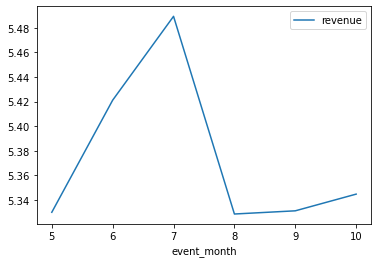

In [31]:
orders.groupby('event_month').agg({'revenue' : 'mean'}).plot()

### Маркетинг:

- Сколько денег потратили? Всего / на каждый источник / по времени

In [32]:
display(ad_costs)
df2 = ad_costs.groupby('channel')['costs'].sum().sort_values(ascending = False)
display(df2)
print(ad_costs.groupby('channel')['costs'].sum().sum())


,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1
...,...,...,...
1795,2019-10-23,lambdaMediaAds,4.0
1796,2019-10-24,lambdaMediaAds,6.4
1797,2019-10-25,lambdaMediaAds,8.8
1798,2019-10-26,lambdaMediaAds,8.8


channel
TipTop                54751.30
FaceBoom              32445.60
WahooNetBanner         5151.00
AdNonSense             3911.25
OppleCreativeMedia     2151.25
RocketSuperAds         1833.00
LeapBob                1797.60
lambdaMediaAds         1557.60
MediaTornado            954.48
YRabbit                 944.22
Name: costs, dtype: float64

105497.30000000002


Text(0, 0.5, 'user_id')

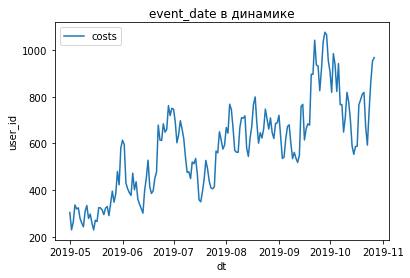

In [33]:
(ad_costs.groupby(['dt'])
    .agg({'costs': 'sum'})).plot()
plt.title('event_date в динамике')
plt.ylabel('user_id')

- Сколько в среднем стоило привлечение одного пользователя из каждого источника?

In [34]:
#df3 = ad_costs.groupby('channel').agg({'costs' : 'sum', 'channel' : 'count'})
#df3['avg_costs'] = df3['costs'] / df3['channel']
#display(profiles)
df3 = profiles.groupby('channel').agg({'acquisition_cost' : 'sum', 'user_id' : 'nunique'})
df3['avg_costs'] = df3['acquisition_cost'] / df3['user_id']
display(df3)

,acquisition_cost,user_id,avg_costs
channel,,,
AdNonSense,3911.25,3880,1.008054
FaceBoom,32445.60,29144,1.113286
LeapBob,1797.60,8553,0.210172
MediaTornado,954.48,4364,0.218717
OppleCreativeMedia,2151.25,8605,0.250000
RocketSuperAds,1833.00,4448,0.412095
TipTop,54751.30,19561,2.799003
WahooNetBanner,5151.00,8553,0.602245
YRabbit,944.22,4312,0.218975


Вывод: Стоимость рекламных компаний очень разница. Надо посмотреть на их эффективность 

# Шаг 4.  Функции для расчета и анализа LTV, ROI, удержания и конверсии

In [35]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

In [36]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [37]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [38]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [39]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 


In [40]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [41]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [42]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()  

# Шаг 5. Оценка окупаемости рекламы для привлечения пользователей

### Проанализируем общую окупаемость рекламы

In [43]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days)

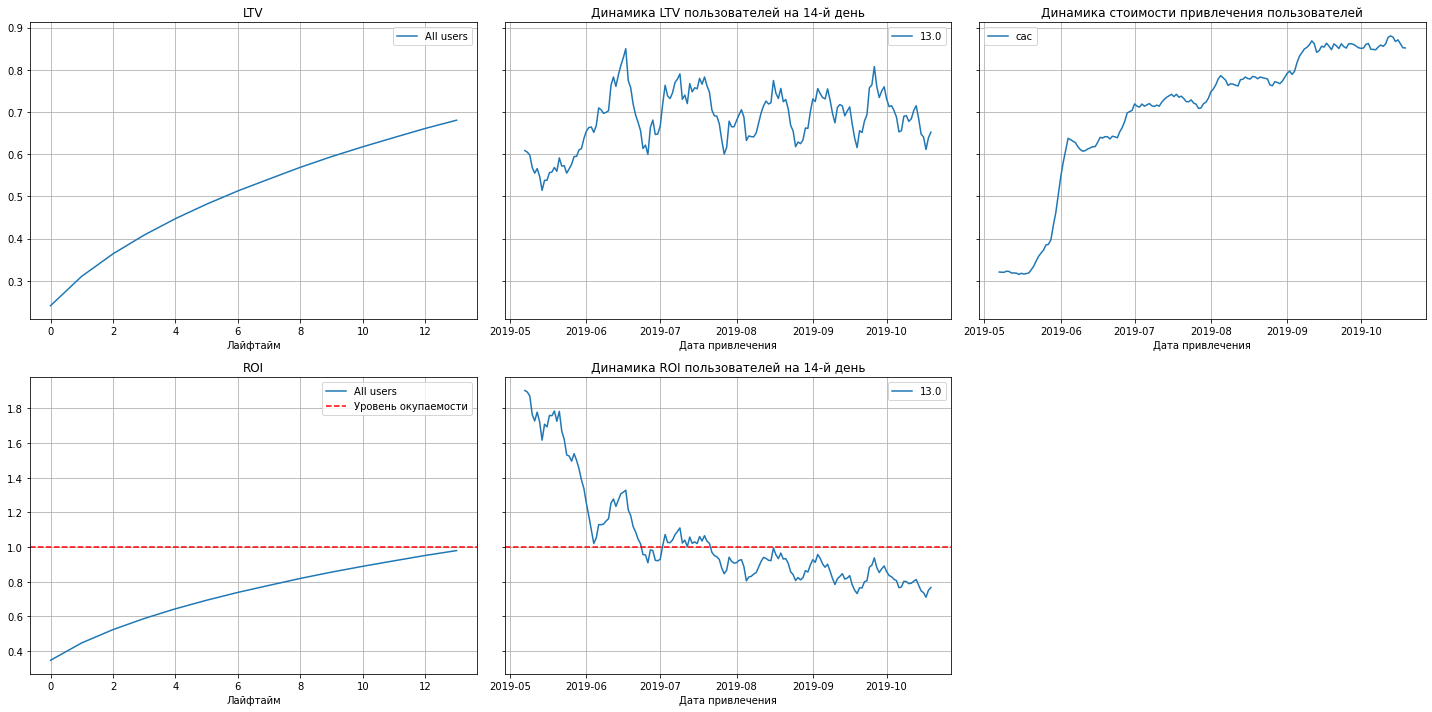

In [44]:
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Вывод: РОИ чуть ниже уровня окуппаемости, LTV стабилен. По динамике можно предположить, что увелечения рекламных бюджетов, не привело к росту прибыли, а на оборот сделало рекламу менее эффективной 

### Проанализируйте окупаемость рекламы с разбивкой по устройствам

In [45]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

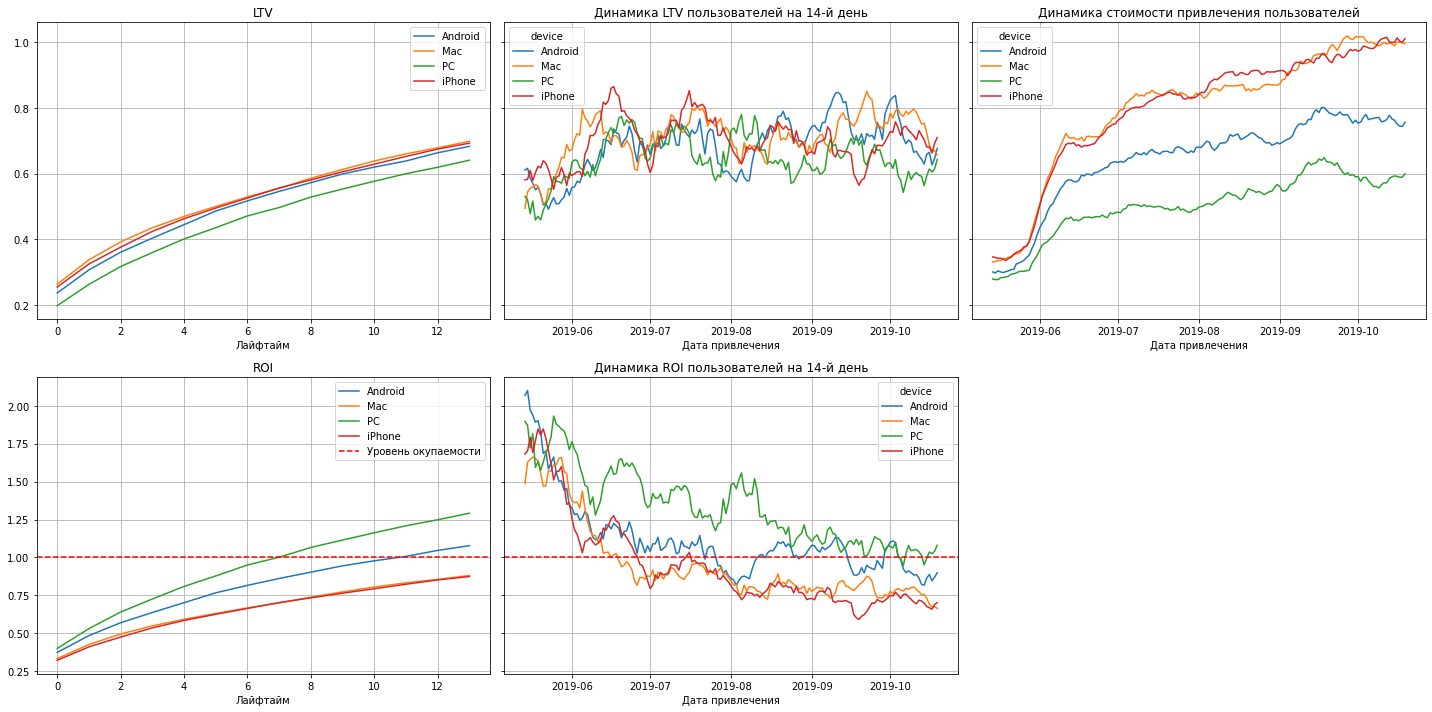

In [46]:
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Вывод: Основные проблемы с окуппаемостью присуствуют на платформах MAC и iPhone, но тренд на снижение окупаемости прослеживается для всех платформ

### Проанализируйте окупаемость рекламы с разбивкой по странам

In [47]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

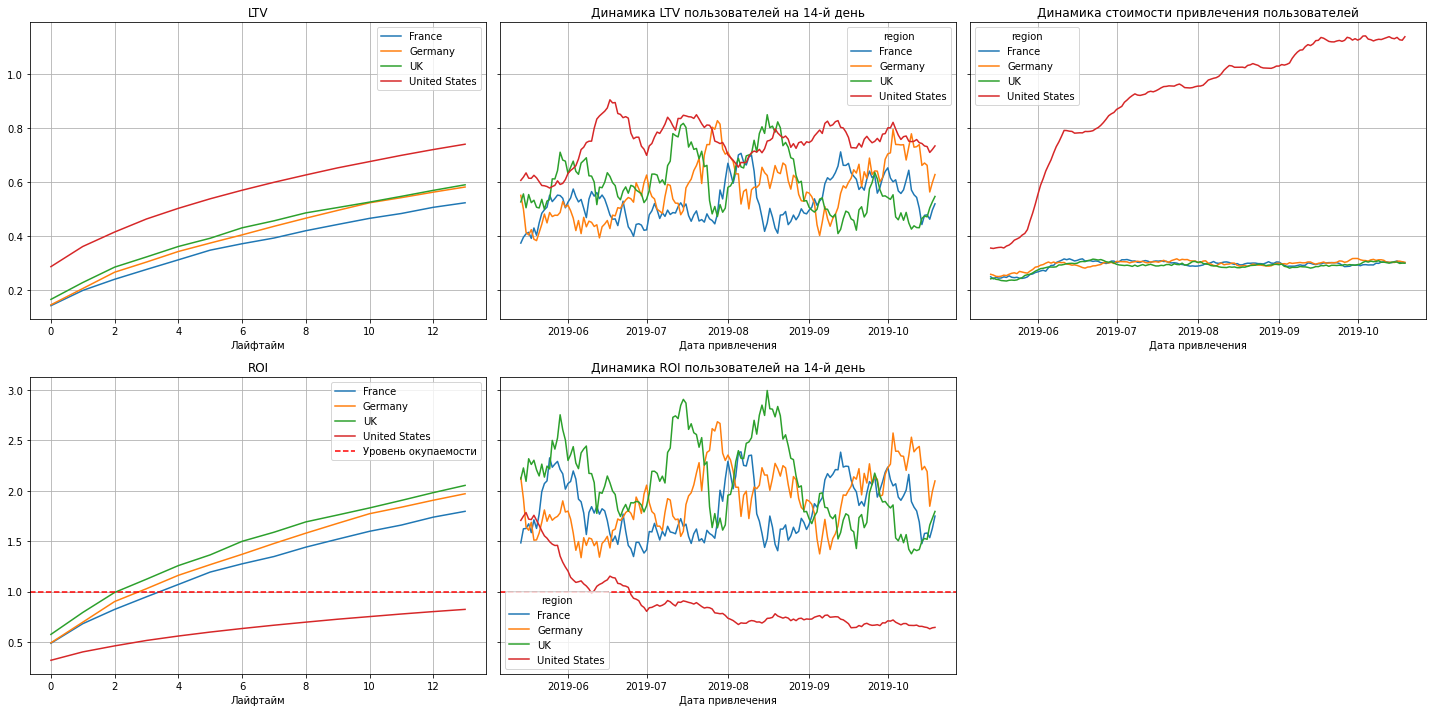

In [48]:
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Вывод: на графиках отчетливо видно,что рекламный бюджет был увеличен только в США, и именно там приложение Procrastinate Pro+ несёт убытки. Когда как на остальных рынках всё стабильно хорошо

### Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам

In [49]:
# смотрим окупаемость с разбивкой по источникам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

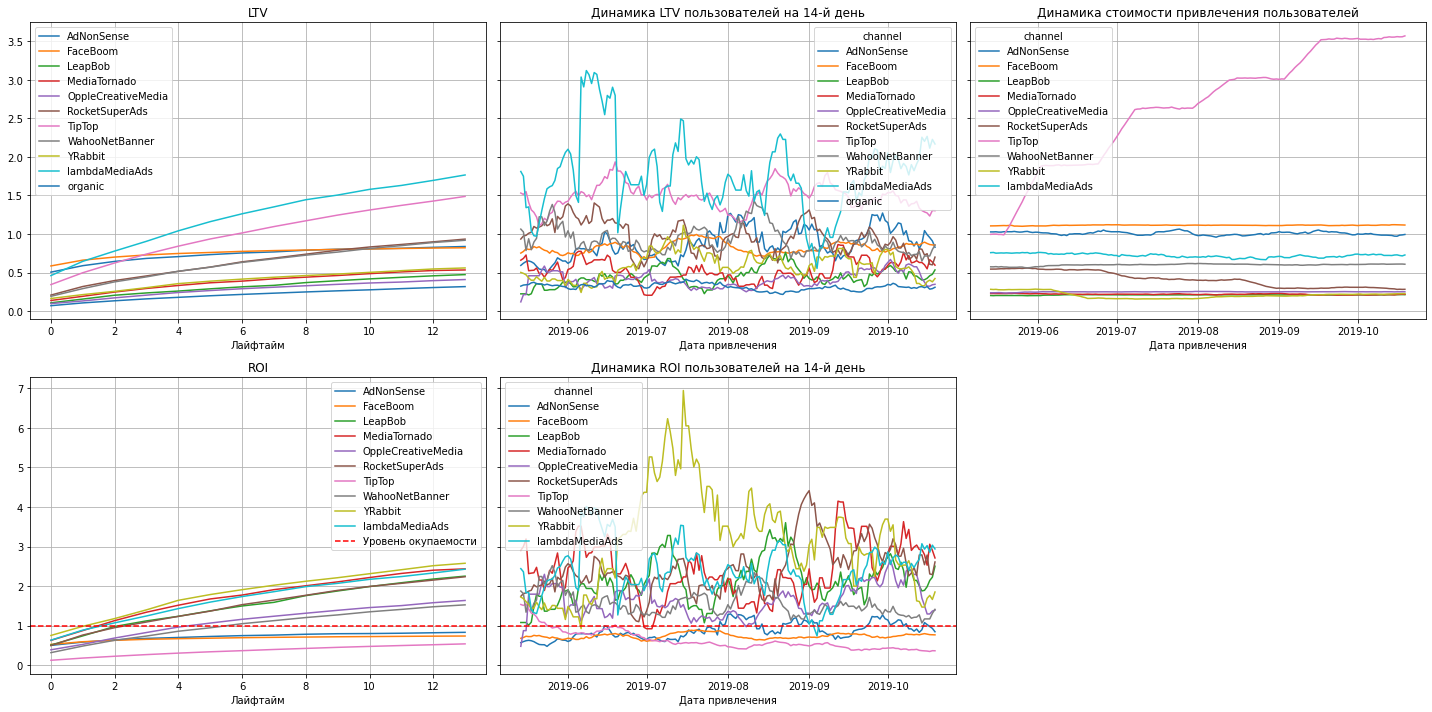

In [50]:
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Вывод: Сразу несколько каналов привлечения показывают малую эффективность. Но основная проблема в TipTope

## Вывод:
Осноная причина не эффективности рекламной компании,во вложение больших средств в продвижение в TipTope
Я рекомендую маркетологам отказаться от этого канала привлечения. А так же более детально изучить возможные проблемы пользователей MAC и IPhone